# Проект: Маркетинг

## Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

## Цель
Предсказать вероятность покупки в течение 90 дней

## План работы

- Загрузить данные
- Провести обзор датафреймов
- Провести предобработку данных
 - Изучить наличие пропусков
 - Изучить наличие дубликатов
- Агрегировать данные
- Исследовать данные
- Обработать признаки
 - Удалить ненужные
 - Добавить новые
- Объеденить 3 датасета в один большой
- Провести анализ корреляции признаков
- Подготовить данные для обучения модели
- Обучить модели
 - Посчитать метрику `roc-auc`
 - Выбрать лучшую модель
- Построить матрицу ошибок

## Описание данных
**apparel-purchases**
история покупок
- `client_id` идентификатор пользователя
- `quantity` количество товаров в заказе
- `price` цена товара
- `category_ids` вложенные категории, к которым отнсится товар
- `date` дата покупки
- `message_id` идентификатор сообщения из рассылки

**apparel-messages**
история рекламных рассылок
- `bulk_campaign_id` идентификатор рекламной кампании
- `client_id` идентификатор пользователя
- `message_id` идентификатор сообщений
- `event` тип действия
- `channel` канал рассылки
- `date` дата рассылки
- `created_at` точное время создания сообщения

**apparel-target_binary**
совершит ли клиент покупку в течение следующих 90 дней
- `client_id` идентификатор пользователя
- `target` целевой признак

# Импорт библиотек и создание функций

In [1]:
!pip install phik -q
!pip install imblearn -q
!pip install xgboost -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip freeze > requirements.txt

In [4]:
def data_exploration_func(df_list):
    for df_current in df_list:
        print(f'Изучение данных датафрейма "{df_current.name}"\n')
        print(f'Первые 10 строк "{df_current.name}"')
        display(df_current.head(10))
        print('\n')
        print(f'"{df_current.name}" состоит из:')
        print(f'{df_current.shape[0]} строк')
        print(f'{df_current.shape[1]} столбцов')
        print('\n')
        print(f'Общая информация о "{df_current.name}"\n')
        df_current.info()
        print('\n')
        print(f'Описательная статистика "{df_current.name}"')
        display(df_current.describe(include='all').T)
        print('\n')

In [5]:
def num_func(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.hist(data, bins=30, ec='black', color='y', alpha=0.5)
    plt.title('Распределение', size=15)
    plt.ylabel('Частота', size=12)
    plt.grid(linestyle='dashed')
    plt.subplot(1,2,2)
    plt.boxplot(data, vert=False)
    plt.title('Ящик с усами', size=15)
    plt.grid(linestyle='dashed')
    plt.show()
    print('Описательная статистика:')
    print(data.describe())

In [6]:
RANDOM_STATE=42

# Загрузка данных и краткий обзор

In [7]:
df_purchases = pd.read_csv('data/apparel-purchases.csv', sep=',', decimal='.')
df_messages = pd.read_csv('data/apparel-messages.csv', sep=',', decimal='.')
df_target = pd.read_csv('data/apparel-target_binary.csv', sep=',', decimal='.')

In [8]:
df_purchases.name = 'df_purchases'
df_messages.name = 'df_messages'
df_target.name = 'df_target'

In [9]:
df_list = [df_purchases, df_messages, df_target]
data_exploration_func(df_list)

Изучение данных датафрейма "df_purchases"

Первые 10 строк "df_purchases"


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2




"df_purchases" состоит из:
202208 строк
6 столбцов


Общая информация о "df_purchases"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Описательная статистика "df_purchases"


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,202208.0,NaN,NaN,NaN,1515915625596210944.0,145945755.930884,1515915625468060928.0,1515915625490081280.0,1515915625557177088.0,1515915625624391936.0,1515915626010443520.0
quantity,202208.0,NaN,NaN,NaN,1.006483,0.184384,1.0,1.0,1.0,1.0,30.0
price,202208.0,NaN,NaN,NaN,1193.301516,1342.252664,1.0,352.0,987.0,1699.0,85499.0
category_ids,202208,933,"['4', '28', '57', '431']",8626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,202208,642,2022-11-11,5270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
message_id,202208,50204,1515915625489095763-6251-6311b13a4cf78,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Изучение данных датафрейма "df_messages"

Первые 10 строк "df_messages"


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06




"df_messages" состоит из:
12739798 строк
7 столбцов


Общая информация о "df_messages"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Описательная статистика "df_messages"


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
bulk_campaign_id,12739798.0,NaN,NaN,NaN,11604.587587,3259.211131,548.0,8746.0,13516.0,14158.0,14657.0
client_id,12739798.0,NaN,NaN,NaN,1515915625574831616.0,132970411.558955,1515915625468060928.0,1515915625489149440.0,1515915625503432192.0,1515915625591286272.0,1515915626010288640.0
message_id,12739798,9061667,1515915625489095763-6251-6311b13a4cf78,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event,12739798,11,send,9058196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel,12739798,2,mobile_push,7512156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,12739798,638,2023-06-10,89661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_at,12739798,4103539,2023-12-29 15:20:53,621,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Изучение данных датафрейма "df_target"

Первые 10 строк "df_target"


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0




"df_target" состоит из:
49849 строк
2 столбцов


Общая информация о "df_target"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Описательная статистика "df_target"


,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,1.927822e-02,1.375025e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Видим, что столбцы с датами имеют тип данных `object`, исправим это

# Предобработка данных

In [10]:
df_purchases['date'] = pd.to_datetime(df_purchases['date'])
df_messages['date'] = pd.to_datetime(df_messages['date'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])

In [11]:
for df in df_list:
    print(f'Пропущенные значения "{df.name}":\n{df.isna().sum()}')
    print('\n')

Пропущенные значения "df_purchases":
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64


Пропущенные значения "df_messages":
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64


Пропущенные значения "df_target":
client_id    0
target       0
dtype: int64




In [12]:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(lambda x: eval(x))

In [13]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843


Переведём значения столбца `category_ids` в списки, чтобы оставить айди первой категории

In [14]:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(
    lambda x: [[item] if not isinstance(item, (list, tuple)) else item for item in x] if isinstance(x, list) else x
)

In [15]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"[[4], [28], [57], [431]]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"[[4], [28], [57], [431]]",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"[[4], [28], [57], [431]]",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"[[4], [28], [244], [432]]",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"[[4], [28], [49], [413]]",2022-05-16,1515915625471138230-4437-6282242f27843


In [16]:
df_purchases['products']=df_purchases['category_ids'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0  and x!=[None] else 'Unknown_product'
)

In [17]:
df_purchases['products'] = df_purchases['products'].apply(str)
df_purchases['category_ids'] = df_purchases['category_ids'].apply(str)

In [18]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,products
0,1515915625468169594,1,1999.0,"[['4'], ['28'], ['57'], ['431']]",2022-05-16,1515915625468169594-4301-627b661e9736d,['4']
1,1515915625468169594,1,2499.0,"[['4'], ['28'], ['57'], ['431']]",2022-05-16,1515915625468169594-4301-627b661e9736d,['4']
2,1515915625471138230,1,6499.0,"[['4'], ['28'], ['57'], ['431']]",2022-05-16,1515915625471138230-4437-6282242f27843,['4']
3,1515915625471138230,1,4999.0,"[['4'], ['28'], ['244'], ['432']]",2022-05-16,1515915625471138230-4437-6282242f27843,['4']
4,1515915625471138230,1,4999.0,"[['4'], ['28'], ['49'], ['413']]",2022-05-16,1515915625471138230-4437-6282242f27843,['4']


Отлично, пропусков нет

In [19]:
for df in df_list:
    print(f'Явные дубликаты "{df.name}":\n{df.duplicated().sum()}')
    print('\n')

Явные дубликаты "df_purchases":
73020


Явные дубликаты "df_messages":
48610


Явные дубликаты "df_target":
0




In [20]:
# Анализ причин дубликатов в df_purchases
duplicates_purchases = df_purchases[df_purchases.duplicated(subset=['client_id', 'category_ids', 'date', 'message_id'], keep=False)]
duplicates_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,products
0,1515915625468169594,1,1999.0,"[['4'], ['28'], ['57'], ['431']]",2022-05-16,1515915625468169594-4301-627b661e9736d,['4']
1,1515915625468169594,1,2499.0,"[['4'], ['28'], ['57'], ['431']]",2022-05-16,1515915625468169594-4301-627b661e9736d,['4']
11,1515915625491869271,2,599.0,"[['4'], ['27'], ['350'], ['1392']]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,['4']
12,1515915625491869271,2,599.0,"[['4'], ['27'], ['350'], ['1392']]",2022-05-16,1515915625491869271-2090-61a72488d6a0f,['4']
20,1515915625566606509,1,349.0,"[['5562'], ['5634'], ['5579'], ['710']]",2022-05-16,1515915625566606509-4301-627b66245401d,['5562']


Анализ дубликатов в `df_purchases` показывает, что некоторые записи имеют одинаковые значения `client_id`, `category_ids`, `date` и `message_id`, но разные значения `quantity` и `price`. Это может указывать на то, что эти записи представляют собой разные покупки, но с одинаковыми идентификаторами.

В таком случае можно агрегировать их по сумме количества и цены

In [21]:
df_purchases = df_purchases.groupby(['client_id', 'products', 'date', 'message_id']).agg({
    'quantity': 'sum',
    'price': 'sum'
}).reset_index()

In [22]:
df_purchases.head()

,client_id,products,date,message_id,quantity,price
0,1515915625468060902,['4'],2022-05-27,1515915625468060902-4617-6290657dac196,7,6993.0
1,1515915625468061003,['4'],2023-01-04,1515915625468061003-9148-63b54b04855a4,7,16235.0
2,1515915625468061099,['4'],2022-05-17,1515915625468061099-4439-62834141aa538,1,299.0
3,1515915625468061100,['4'],2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,2,2098.0
4,1515915625468061170,Unknown_product,2023-03-26,1515915625468061170-11144-641ad2cda77a2,2,14.0


После этого можем спокойно удалить дубли

In [23]:
df_purchases = df_purchases.drop_duplicates()

In [24]:
df_purchases.head()

,client_id,products,date,message_id,quantity,price
0,1515915625468060902,['4'],2022-05-27,1515915625468060902-4617-6290657dac196,7,6993.0
1,1515915625468061003,['4'],2023-01-04,1515915625468061003-9148-63b54b04855a4,7,16235.0
2,1515915625468061099,['4'],2022-05-17,1515915625468061099-4439-62834141aa538,1,299.0
3,1515915625468061100,['4'],2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,2,2098.0
4,1515915625468061170,Unknown_product,2023-03-26,1515915625468061170-11144-641ad2cda77a2,2,14.0


In [25]:
# Анализ причин дубликатов в df_messages
duplicates_messages = df_messages[df_messages.duplicated(subset=['client_id', 'message_id', 'event', 'channel', 'date', 'created_at'], keep=False)]
duplicates_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966465,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967281,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56


Тут мы видим повторные записи одногои того же события. Дубликатов очень мало по сравнению с всей выборкой, поэтому можем спокойно их удалить

In [26]:
df_messages = df_messages.drop_duplicates()

### Вывод
Удалили дубли и разобрались со столбцом `category_ids`

# Исследовательский анализ

Text(0.5, 0.98, 'Распределения данных для числовых столбцов "df_train"')

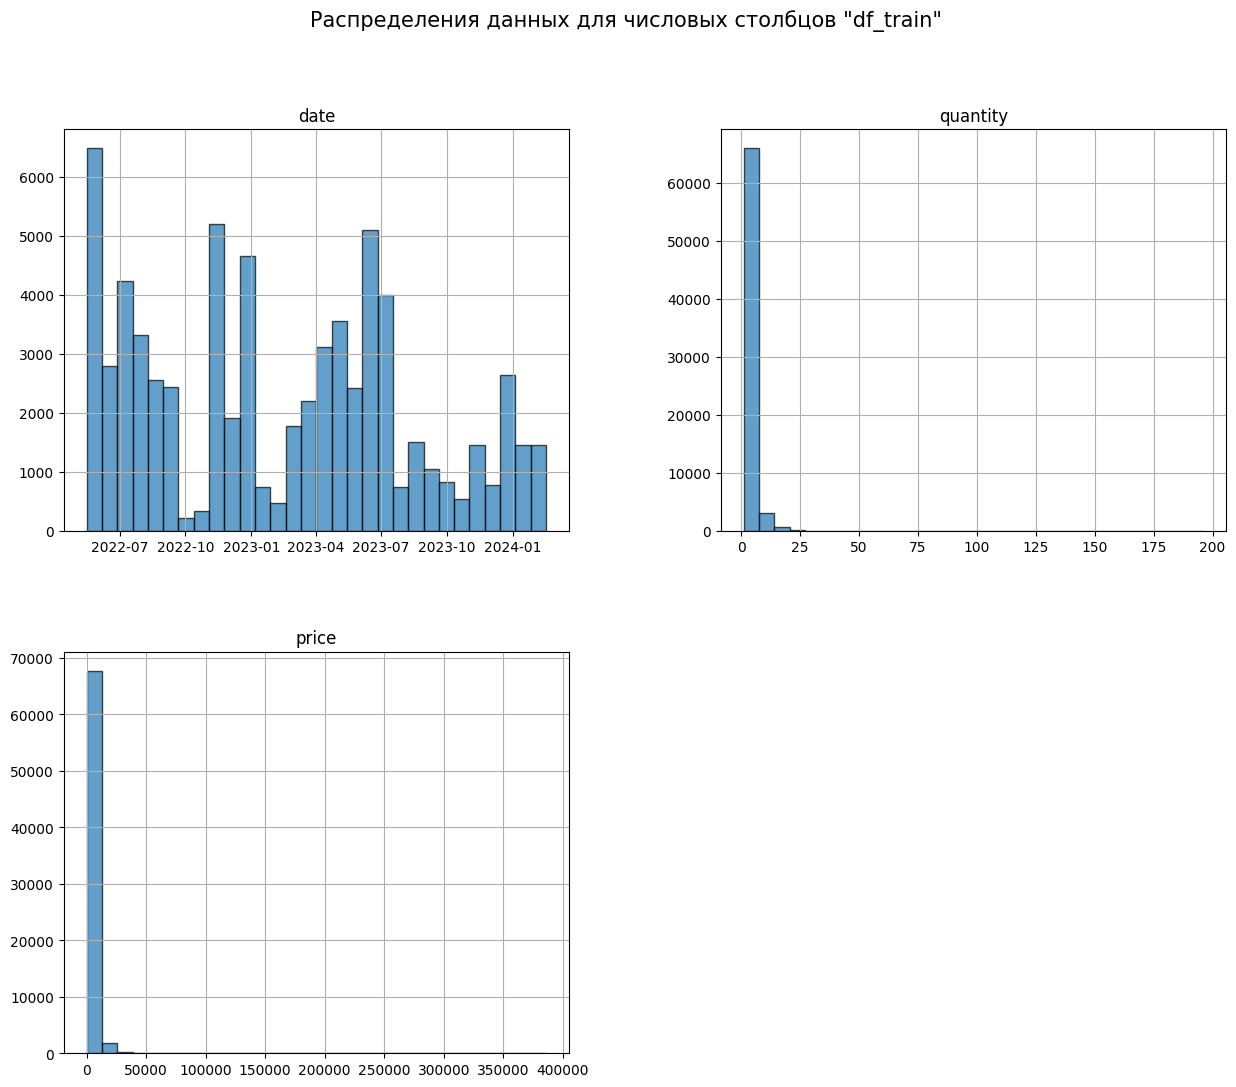

In [27]:
df_purchases.drop('client_id', axis=1).hist(figsize=(15, 12), ec='black', alpha=0.7, bins=30)
plt.suptitle('Распределения данных для числовых столбцов "df_train"', size=15)

Столбец "quantity"


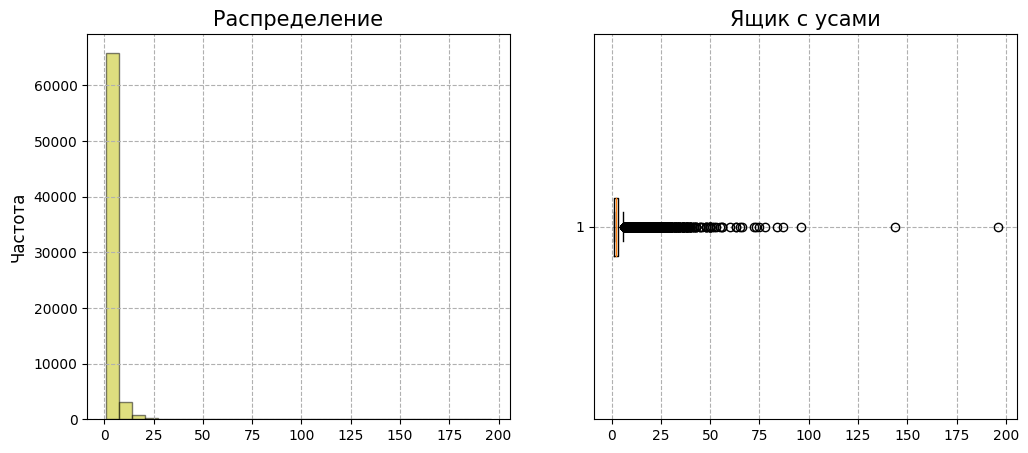

Описательная статистика:
count    69990.000000
mean         2.907830
std          3.329445
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        196.000000
Name: quantity, dtype: float64


Столбец "price"


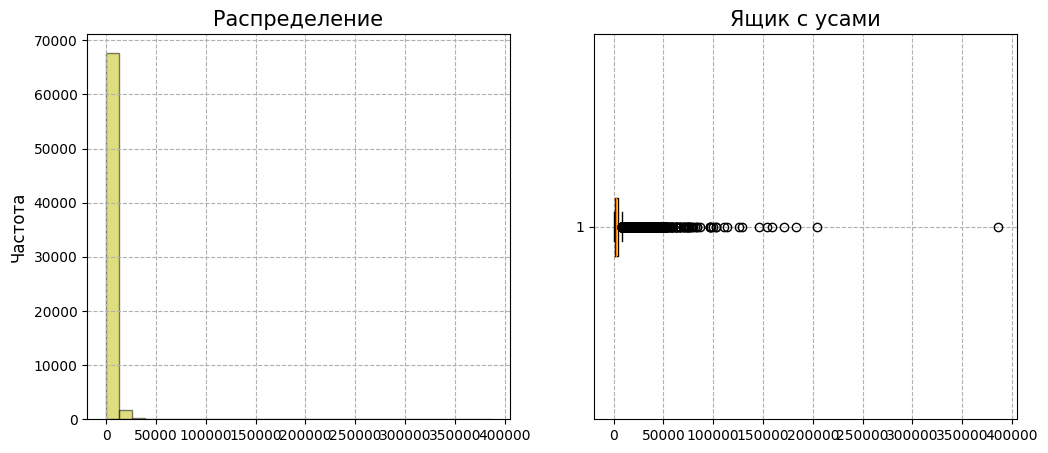

Описательная статистика:
count     69990.000000
mean       3447.565552
std        5136.773735
min           1.000000
25%         999.000000
50%        2098.000000
75%        4097.000000
max      385986.000000
Name: price, dtype: float64




In [28]:
df_purchases_num = df_purchases[df_purchases.select_dtypes(include='number').columns].drop(['client_id'], axis=1)
for i in df_purchases_num:
    print(f'Столбец "{i}"')
    num_func(df_purchases_num[i])
    plt.show()
    print('\n')

In [29]:
df_purchases.loc[df_purchases['quantity'] > 60]

,client_id,products,date,message_id,quantity,price
4539,1515915625470883759,['5562'],2022-11-04,1515915625470883759-7602-6364bc1f886ac,87,6392.0
6987,1515915625475422624,['4'],2022-06-04,1515915625475422624-4679-6297222055c5e,73,87127.0
10960,1515915625488041632,['5562'],2022-09-09,1515915625488041632-6336-63198505ee106,96,192.0
19664,1515915625490352441,['4'],2023-07-06,1515915625490352441-13443-64a52fa882390,75,47166.0
23334,1515915625491335784,['5562'],2023-06-07,1515915625491335784-13160-647ef99486be0,66,34779.0
25263,1515915625491913953,['4'],2023-06-11,1515915625558824236-13319-64851ce067caa,63,10735.0
26992,1515915625500440898,['5562'],2023-08-31,1515915625500440898-13744-64f03a9718817,63,2158.0
36185,1515915625557342756,['4'],2023-03-23,1515915625502147758-11144-641ad21091eec,84,126253.0
37201,1515915625558517454,['5562'],2022-11-04,1515915625567363010-7576-63637523deb92,72,5419.0
40183,1515915625559931867,['5562'],2023-08-05,1515915625559931867-13598-64cd08c473b82,78,58538.0


Здесь мы видим высокое значение столбца `quantity`, но у двух строк одинаковые `category_ids`, из чего можно сделать вывод, что это такой товар, который может требоваться в большом количестве. Думаю не нужно удалять эти строки 

Так же мы может наблюдать, что есть одно очень высокое значение в столбце `price`, но оно может быть настоящим

# Создадим новые признаки

In [30]:
last_purchase_date = df_purchases.groupby('client_id')['date'].max().reset_index(name='last_purchase_date')
last_purchase_date.sort_values(by='last_purchase_date')

,client_id,last_purchase_date
29080,1515915625566606509,2022-05-16
3081,1515915625471138230,2022-05-16
17179,1515915625491757718,2022-05-16
16622,1515915625491478747,2022-05-16
14704,1515915625490739153,2022-05-16
...,...,...
41946,1515915625780966033,2024-02-16
28133,1515915625559964084,2024-02-16
13347,1515915625490284825,2024-02-16
49353,1515915626000416409,2024-02-16


Последняя дата заказа - `2024-02-16`. За дату выгрузки будем считать - `2024-02-17`

In [31]:
# Преобразуем столбец 'date' в тип данных datetime, если это еще не сделано
df_purchases['date'] = pd.to_datetime(df_purchases['date'])

# Общее количество покупок
df_purchases['total_purchases'] = df_purchases.groupby('client_id')['quantity'].transform('sum')

# Общая сумма покупок
df_purchases['total_spent'] = df_purchases.groupby('client_id')['price'].transform('sum')

# Средняя цена покупки
df_purchases['avg_price'] = df_purchases.groupby('client_id')['price'].transform('mean')

# Время с последней покупки
df_purchases['last_purchase_date'] = df_purchases.groupby('client_id')['date'].transform('max')
df_purchases['days_since_last_purchase'] = (pd.to_datetime('2024-02-17') - df_purchases['last_purchase_date']).dt.days

# Время с первой покупки
df_purchases['first_purchase_date'] = df_purchases.groupby('client_id')['date'].transform('min')
df_purchases['days_since_first_purchase'] = (pd.to_datetime('2024-02-17') - df_purchases['first_purchase_date']).dt.days

In [32]:
df_purchases.head()

,client_id,products,date,message_id,quantity,price,total_purchases,total_spent,avg_price,last_purchase_date,days_since_last_purchase,first_purchase_date,days_since_first_purchase
0,1515915625468060902,['4'],2022-05-27,1515915625468060902-4617-6290657dac196,7,6993.0,7,6993.0,6993.00,2022-05-27,631,2022-05-27,631
1,1515915625468061003,['4'],2023-01-04,1515915625468061003-9148-63b54b04855a4,7,16235.0,7,16235.0,16235.00,2023-01-04,409,2023-01-04,409
2,1515915625468061099,['4'],2022-05-17,1515915625468061099-4439-62834141aa538,1,299.0,1,299.0,299.00,2022-05-17,641,2022-05-17,641
3,1515915625468061100,['4'],2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,2,2098.0,2,2098.0,2098.00,2024-02-10,7,2024-02-10,7
4,1515915625468061170,Unknown_product,2023-03-26,1515915625468061170-11144-641ad2cda77a2,2,14.0,19,33601.0,8400.25,2023-06-17,245,2023-03-26,328


Создали новые признаки для датафрейма `df_purchases`

In [33]:
df_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

Имеет смысл удалить строки, в которых значения `event` равны `hard_bounce`, `soft_bounce`, `complain` и `hbq_spam`. Эти события не несут полезной информации для предсказания покупок и могут исказить результаты моделирования.

In [34]:
df_messages = df_messages[~df_messages['event'].isin(['hard_bounce', 'soft_bounce', 'complain', 'hbq_spam'])]

In [35]:
# Агрегируем данные по клиентам
df_messages_agg = df_messages.groupby('client_id').agg({
    'event': lambda x: x.value_counts().to_dict(),
    'channel': lambda x: x.value_counts().to_dict(),
    'bulk_campaign_id': lambda x: x.value_counts().to_dict(),
    'date': ['min', 'max']
}).reset_index()

# Приведение к плоскому виду
df_messages_agg.columns = ['client_id', 'event_counts', 'channel_counts', 'campaign_counts', 'first_message_date', 'last_message_date']

In [36]:
df_messages_agg.head()

,client_id,event_counts,channel_counts,campaign_counts,first_message_date,last_message_date
0,1515915625468060902,"{'send': 126, 'open': 35, 'click': 10, 'purcha...",{'email': 177},"{4617: 11, 6316: 4, 14439: 4, 14502: 3, 7180: ...",2022-05-19,2024-01-19
1,1515915625468061003,"{'send': 154, 'click': 5, 'open': 5, 'purchase...",{'email': 165},"{12566: 4, 9148: 4, 14149: 3, 10988: 3, 7290: ...",2022-05-20,2024-02-13
2,1515915625468061099,"{'send': 215, 'open': 51, 'click': 8}","{'email': 182, 'mobile_push': 92}","{9945: 4, 7818: 3, 5939: 3, 13358: 3, 7602: 3,...",2022-05-19,2024-02-13
3,1515915625468061100,"{'send': 267, 'open': 157, 'purchase': 1, 'cli...",{'mobile_push': 426},"{14280: 8, 14623: 4, 13364: 3, 13319: 3, 13371...",2022-05-19,2024-02-15
4,1515915625468061170,"{'send': 243, 'open': 31, 'click': 16, 'purcha...","{'email': 202, 'mobile_push': 91}","{11144: 7, 11208: 4, 6289: 4, 6374: 4, 12218: ...",2022-05-25,2024-02-15


In [37]:
# Общее количество сообщений
df_messages_agg['total_messages'] = df_messages_agg['event_counts'].apply(lambda x: sum(x.values()))

# Количество открытых сообщений
df_messages_agg['opened_messages'] = df_messages_agg['event_counts'].apply(lambda x: x.get('open', 0))

# Количество кликов по сообщениям
df_messages_agg['clicked_messages'] = df_messages_agg['event_counts'].apply(lambda x: x.get('click', 0))

# Количество покупок после получения сообщения
df_messages_agg['purchased_messages'] = df_messages_agg['event_counts'].apply(lambda x: x.get('purchase', 0))

# Количество отписок
df_messages_agg['unsubscribed_messages'] = df_messages_agg['event_counts'].apply(lambda x: x.get('unsubscribe', 0))

# Количество подписок
df_messages_agg['subscribed_messages'] = df_messages_agg['event_counts'].apply(lambda x: x.get('subscribe', 0))

# Количество закрытий сообщений
df_messages_agg['closed_messages'] = df_messages_agg['event_counts'].apply(lambda x: x.get('close', 0))

# Время с последнего сообщения
df_messages_agg['days_since_last_message'] = (pd.to_datetime('2024-02-17') - df_messages_agg['last_message_date']).dt.days

# Время с первого сообщения
df_messages_agg['days_since_first_message'] = (pd.to_datetime('2024-02-17') - df_messages_agg['first_message_date']).dt.days

# Доля открытых сообщений
df_messages_agg['open_rate'] = df_messages_agg['opened_messages'] / df_messages_agg['total_messages']

# Доля кликов по сообщениям
df_messages_agg['click_rate'] = df_messages_agg['clicked_messages'] / df_messages_agg['total_messages']

# Доля покупок после получения сообщения
df_messages_agg['purchase_rate'] = df_messages_agg['purchased_messages'] / df_messages_agg['total_messages']

# Доля отписок
df_messages_agg['unsubscribe_rate'] = df_messages_agg['unsubscribed_messages'] / df_messages_agg['total_messages']

# Доля подписок
df_messages_agg['subscribe_rate'] = df_messages_agg['subscribed_messages'] / df_messages_agg['total_messages']

# Доля закрытий сообщений
df_messages_agg['close_rate'] = df_messages_agg['closed_messages'] / df_messages_agg['total_messages']

# Количество сообщений по каждому каналу
for channel in df_messages['channel'].unique():
    df_messages_agg[f'channel_{channel}_count'] = df_messages_agg['channel_counts'].apply(lambda x: x.get(channel, 0))

In [38]:
df_purchases = df_purchases.drop_duplicates(subset='client_id')

### Вывод
Создали новые признаки

# Объединение датафреймов

In [39]:
# Объединение df_purchases и df_messages_agg по client_id
merged_df = pd.merge(df_purchases, df_messages_agg, on='client_id', how='left')

# Объединение merged_df и df_target по client_id
final_df = pd.merge(merged_df, df_target, on='client_id', how='left')

In [40]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   client_id                  49849 non-null  int64         
 1   products                   49849 non-null  object        
 2   date                       49849 non-null  datetime64[ns]
 3   message_id                 49849 non-null  object        
 4   quantity                   49849 non-null  int64         
 5   price                      49849 non-null  float64       
 6   total_purchases            49849 non-null  int64         
 7   total_spent                49849 non-null  float64       
 8   avg_price                  49849 non-null  float64       
 9   last_purchase_date         49849 non-null  datetime64[ns]
 10  days_since_last_purchase   49849 non-null  int64         
 11  first_purchase_date        49849 non-null  datetime64[ns]
 12  days

In [41]:
final_df.head().T

,0,1,2,3,4
client_id,1515915625468060902,1515915625468061003,1515915625468061099,1515915625468061100,1515915625468061170
products,['4'],['4'],['4'],['4'],Unknown_product
date,2022-05-27 00:00:00,2023-01-04 00:00:00,2022-05-17 00:00:00,2024-02-10 00:00:00,2023-03-26 00:00:00
message_id,1515915625468060902-4617-6290657dac196,1515915625468061003-9148-63b54b04855a4,1515915625468061099-4439-62834141aa538,1515915625468061100-14623-65c5c55eeb9e0,1515915625468061170-11144-641ad2cda77a2
quantity,7,7,1,2,2
price,6993.0,16235.0,299.0,2098.0,14.0
total_purchases,7,7,1,2,19
total_spent,6993.0,16235.0,299.0,2098.0,33601.0
avg_price,6993.0,16235.0,299.0,2098.0,8400.25
last_purchase_date,2022-05-27 00:00:00,2023-01-04 00:00:00,2022-05-17 00:00:00,2024-02-10 00:00:00,2023-06-17 00:00:00


In [42]:
# Удаление столбцов со словарями
final_df_clean = final_df.drop(columns=['event_counts', 'channel_counts', 'campaign_counts'])

### Вывод
Объединили датафреймы, подготовили датафрейм для корреляционного анализа

# Корреляционный анализ

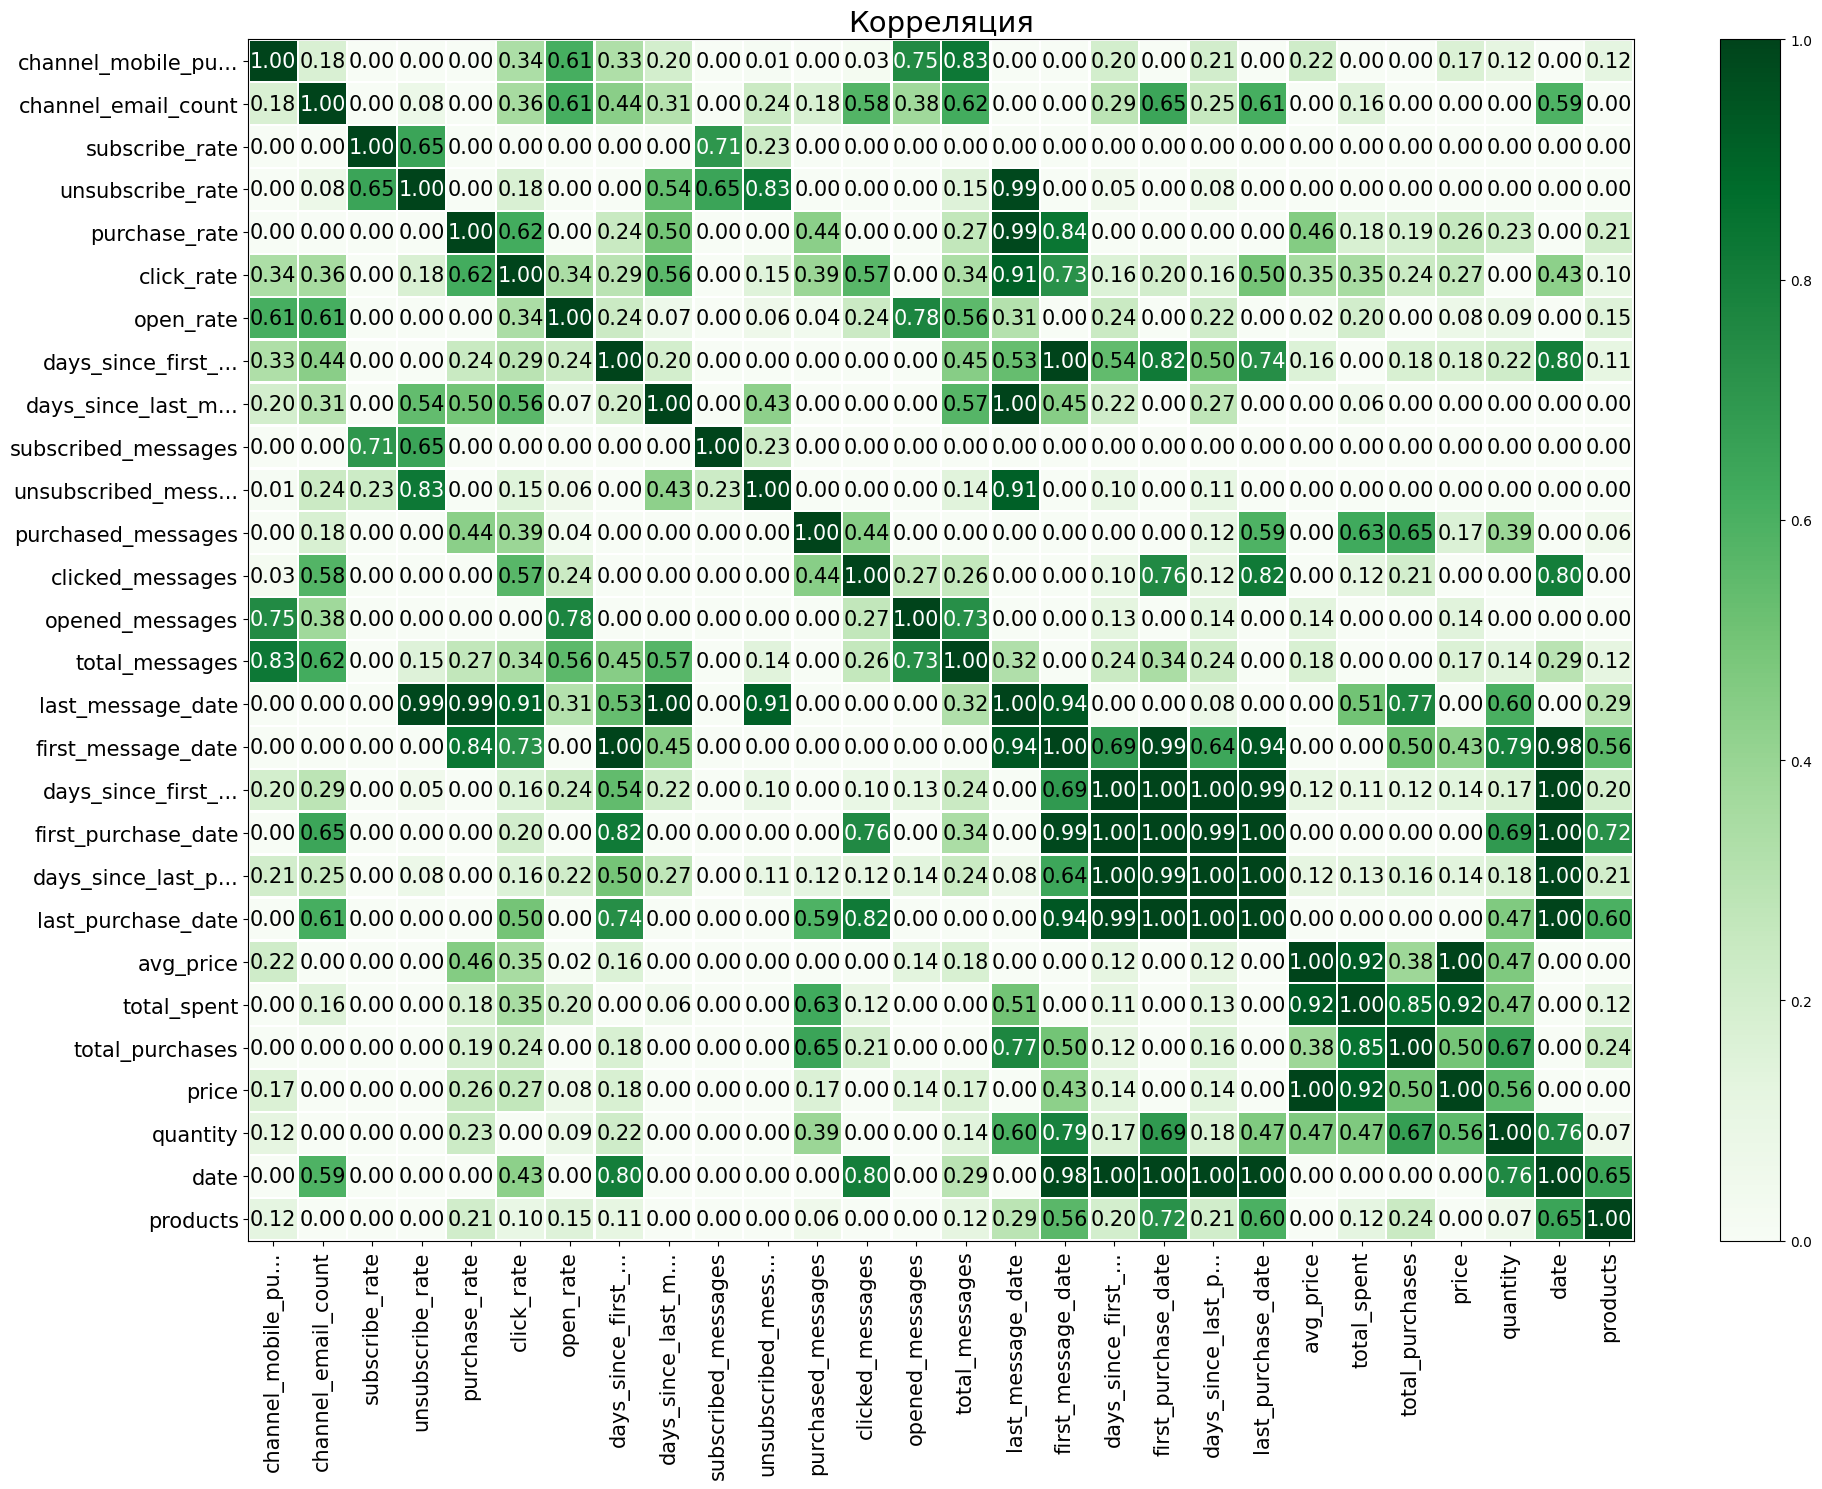

In [43]:
phik_overview = (
    final_df_clean.sample(1000)
    .drop(['target', 'message_id', 'client_id'], axis=1)
    .phik_matrix(verbose=False)
)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Корреляция',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

In [44]:
final_df_clean = final_df_clean.drop(['subscribe_rate', 'unsubscribe_rate', 'last_purchase_date', 'last_message_date', 'first_message_date', 'date', 'days_since_last_purchase', 'first_purchase_date', 'message_id', 'client_id'], axis=1)

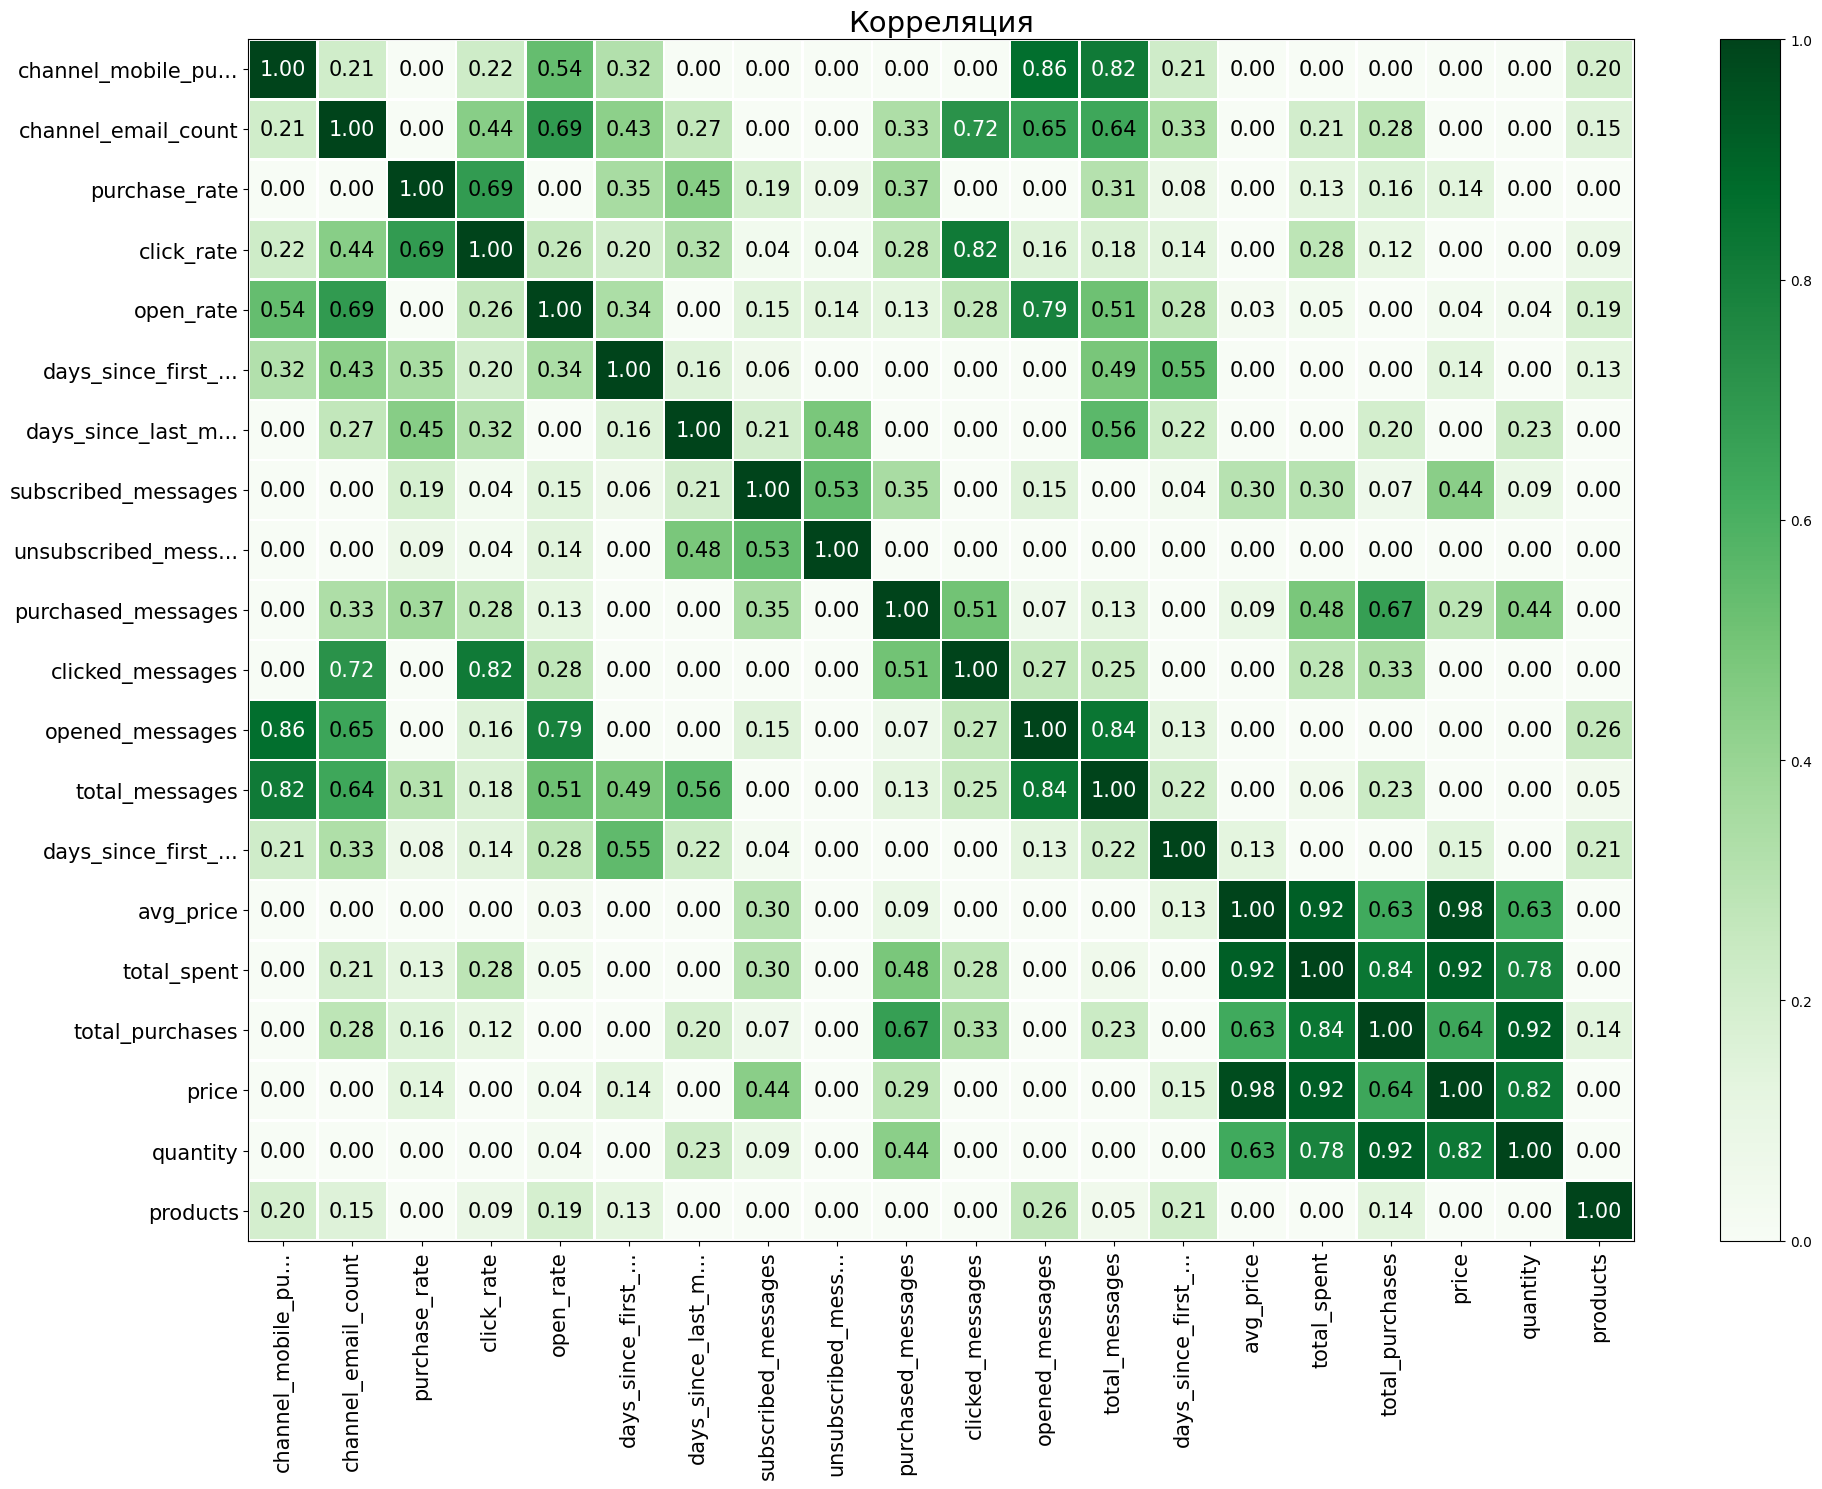

In [45]:
phik_overview = (
    final_df_clean.sample(1000)
    .drop(['target'], axis=1)
    .phik_matrix(verbose=False)
)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Корреляция',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Убрали мультиколлинеарность, но мне интересно, почему образовывается такой "зелёный квадрат" в правом нижнем углу?

In [46]:
final_df_clean['target'].value_counts()

0    48888
1      961
Name: target, dtype: int64

In [47]:
final_df_clean[final_df_clean.isnull().any(axis=1)]

,products,quantity,price,total_purchases,total_spent,avg_price,days_since_first_purchase,total_messages,opened_messages,clicked_messages,...,closed_messages,days_since_last_message,days_since_first_message,open_rate,click_rate,purchase_rate,close_rate,channel_email_count,channel_mobile_push_count,target
293,Unknown_product,2,10.0,5,7924.0,3962.000000,421,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
347,['4'],7,2183.0,13,2527.0,1263.500000,623,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
418,['2'],2,6498.0,37,88432.0,9825.777778,621,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
564,['4'],4,5496.0,7,8793.0,4396.500000,142,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
777,['4'],1,2399.0,1,2399.0,2399.000000,622,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49843,['5562'],2,3998.0,2,3998.0,3998.000000,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
49845,['4'],2,1818.0,2,1818.0,1818.000000,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
49846,['4'],2,198.0,2,198.0,198.000000,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
49847,['2'],1,1999.0,1,1999.0,1999.000000,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [48]:
final_df_clean = final_df_clean.fillna('Missing')

### Вывод
Устранили мультиколлинеарность и заполнили пропуски, которые возникли из-за того, что не всем пользователям из таргета были отправлены рекламные письма

# Обучение моделей

In [49]:
target = final_df_clean['target']
features = final_df_clean.drop('target', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [50]:
target.value_counts()

0    48888
1      961
Name: target, dtype: int64

In [51]:
final_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   products                   49849 non-null  object 
 1   quantity                   49849 non-null  int64  
 2   price                      49849 non-null  float64
 3   total_purchases            49849 non-null  int64  
 4   total_spent                49849 non-null  float64
 5   avg_price                  49849 non-null  float64
 6   days_since_first_purchase  49849 non-null  int64  
 7   total_messages             49849 non-null  object 
 8   opened_messages            49849 non-null  object 
 9   clicked_messages           49849 non-null  object 
 10  purchased_messages         49849 non-null  object 
 11  unsubscribed_messages      49849 non-null  object 
 12  subscribed_messages        49849 non-null  object 
 13  closed_messages            49849 non-null  obj

In [52]:
final_df_clean.head(1).T

,0
products,['4']
quantity,7
price,6993.0
total_purchases,7
total_spent,6993.0
avg_price,6993.0
days_since_first_purchase,631
total_messages,177.0
opened_messages,35.0
clicked_messages,10.0


In [53]:
final_df_clean.columns

Index(['products', 'quantity', 'price', 'total_purchases', 'total_spent',
       'avg_price', 'days_since_first_purchase', 'total_messages',
       'opened_messages', 'clicked_messages', 'purchased_messages',
       'unsubscribed_messages', 'subscribed_messages', 'closed_messages',
       'days_since_last_message', 'days_since_first_message', 'open_rate',
       'click_rate', 'purchase_rate', 'close_rate', 'channel_email_count',
       'channel_mobile_push_count', 'target'],
      dtype='object')

Есть дисбаланс классов

In [54]:
# Определение колонок
ohe_column = ['products', 'total_messages',
       'opened_messages', 'clicked_messages', 'purchased_messages',
       'unsubscribed_messages', 'subscribed_messages', 'closed_messages',
       'days_since_last_message', 'days_since_first_message', 'open_rate',
       'click_rate', 'purchase_rate', 'close_rate', 'channel_email_count',
       'channel_mobile_push_count']
num_column = ['quantity',
              'price',
              'total_purchases',
              'total_spent',
              'avg_price',
              'days_since_first_purchase']

for col in ohe_column:
    features_train[col] = features_train[col].astype(str)
    features_test[col] = features_test[col].astype(str)

In [55]:
# Определение пайплайнов
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Препроцессор
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_column),
        ('num', MinMaxScaler(), num_column)
    ],
    remainder='passthrough'
)

# Окончательный пайплайн без SMOTE
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('SMOTE', SMOTE(random_state=RANDOM_STATE)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Параметры для RandomizedSearchCV
param_grid = [
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel='linear',
            probability=True
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__learning_rate': [0.01, 0.1],
        'models__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
    'models': [XGBClassifier(random_state=RANDOM_STATE)],
    'models__n_estimators': [100, 200],
    'models__learning_rate': [0.01, 0.1],
    'models__max_depth': [3, 5],
    'models__scale_pos_weight': [1, 5, 10]  # Взвешивание классов
}
]

# RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=4
)

# Обучение модели
randomized_search.fit(features_train.head(1000), target_train.head(1000))

# Предсказание вероятностей
proba = randomized_search.predict_proba(features_test)
proba_one = proba[:, 1]

# Вывод результатов
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('\n')
print('Параметры лучшей модели:\n', randomized_search.best_params_)
print('\n')
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print('\n')
print('Метрика ROC-AUC на тестовой выборке:', round(roc_auc_score(target_test, proba_one), 3))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['products', 'total_messages',
                                                   'opened_messages',
                                                   'clicked_messages',
                                                   'purchased_messages',
                                                   'unsubscribed_messages',
                                                   'subscribed_mes

In [56]:
pd.DataFrame(randomized_search.cv_results_)[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
1,1,"SVC(kernel='linear', probability=True, random_...",0.608619,"{'preprocessor__num': MinMaxScaler(), 'models_..."
0,2,"SVC(kernel='linear', probability=True, random_...",0.606010,"{'preprocessor__num': StandardScaler(), 'model..."
7,3,"XGBClassifier(base_score=None, booster=None, c...",0.576520,"{'models__scale_pos_weight': 1, 'models__n_est..."
5,4,"XGBClassifier(base_score=None, booster=None, c...",0.554368,"{'models__scale_pos_weight': 1, 'models__n_est..."
9,5,"XGBClassifier(base_score=None, booster=None, c...",0.549821,"{'models__scale_pos_weight': 1, 'models__n_est..."
6,6,GradientBoostingClassifier(random_state=42),0.544809,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,7,"XGBClassifier(base_score=None, booster=None, c...",0.538482,"{'models__scale_pos_weight': 1, 'models__n_est..."
2,8,"XGBClassifier(base_score=None, booster=None, c...",0.534551,"{'models__scale_pos_weight': 1, 'models__n_est..."
4,9,KNeighborsClassifier(),0.461250,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,10,KNeighborsClassifier(),0.378590,"{'preprocessor__num': StandardScaler(), 'model..."


In [57]:
y_pred = randomized_search.predict(features_test)

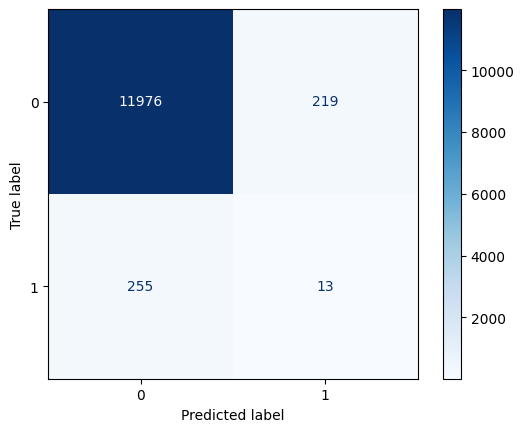

In [58]:
# Вычисление confusion matrix
cm = confusion_matrix(target_test, y_pred)

# Визуализация confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=randomized_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [59]:
# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(target_test, proba_one)
roc_auc = auc(fpr, tpr)

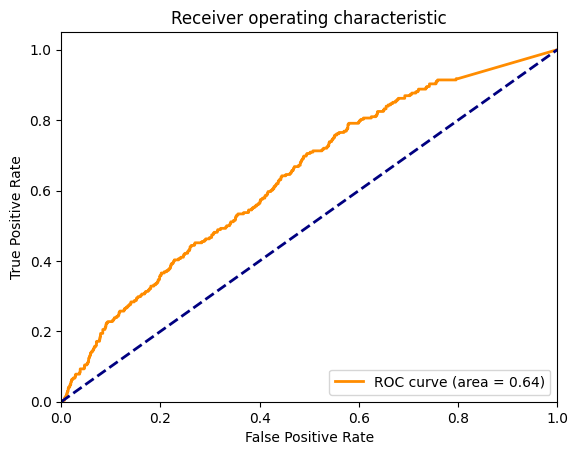

In [60]:
# Вывод ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Вывод
Лучшей моделью оказалась `SVC(kernel='linear', probability=True, random_state=42)` с такими параметрами:
- `preprocessor__num`: MinMaxScaler()
- `models__C`: 3

Метрика лучшей модели на тренировочной выборке: 0.6086185243328102


Метрика ROC-AUC на тестовой выборке: 0.638